In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import shap
import joblib 
pd.options.display.max_columns = None

/Users/rachaelsaxon/Documents/Projects/Side Projects/RED Settlement Predictor/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
df = pd.read_csv('uk_dilapidations_dataset.csv')
df['Lease_End'] = pd.to_datetime(df['Lease_End'])
df['Lease_Start'] = pd.to_datetime(df['Lease_Start'])
df['Lease_Length_Years'] = (df['Lease_End'] - df['Lease_Start']).dt.days / 365.25
df.head()

,Property_ID,Property_Type,Location,Size_sqft,EPC_Rating,Year_Built,Lease_Start,Lease_End,Repairing_Obligation,Schedule_of_Condition,Tenant_Type,Tenant_Industry,Tenant_Solvency,Survey_Score,Defects_Identified,Original_Claim_Amount,Negotiated,Legal_Dispute,Mediation_Used,Time_to_Settlement_Days,Settlement_Amount,Lease_Length_Years
0,P001,Industrial,Leeds,6592,A,1981,2003-01-01,2019-01-01,Full Repairing,True,Corporate,Retail,Moderate,9.2,13,144938,No,No,No,91,50832,16.000000
1,P002,Office,Leeds,12494,A,1996,2014-01-01,2024-01-01,Partial,True,Charity,Healthcare,Strong,2.1,12,109599,Yes,Yes,No,267,32275,9.998631
2,P003,Industrial,Leeds,11429,B,1972,2009-01-01,2021-01-01,Internal Only,True,Charity,Healthcare,Weak,3.1,4,92355,Yes,Yes,Yes,215,23208,12.000000
3,P004,Industrial,Birmingham,8392,A,2015,2009-01-01,2018-01-01,Partial,True,Corporate,Education,Weak,2.5,5,111248,Yes,No,No,86,34890,8.999316
4,P005,Office,Birmingham,14696,C,1976,2002-01-01,2016-01-01,Full Repairing,False,Public Sector,Education,Weak,2.7,25,44762,No,Yes,Yes,21,16588,13.998631


In [15]:
df.loc[df['EPC_Rating'] == 'A', 'EPC_Rating'] = 5 
df.loc[df['EPC_Rating'] == 'B', 'EPC_Rating'] = 4
df.loc[df['EPC_Rating'] == 'C', 'EPC_Rating'] = 3
df.loc[df['EPC_Rating'] == 'D', 'EPC_Rating'] = 2
df.loc[df['EPC_Rating'] == 'E', 'EPC_Rating'] = 1
df['EPC_Rating'] = df['EPC_Rating'].astype(int)
df.loc[df['Schedule_of_Condition'] == False, 'Schedule_of_Condition'] = 0
df.loc[df['Schedule_of_Condition'] == True, 'Schedule_of_Condition'] = 1
df['Schedule_of_Condition'] = df['Schedule_of_Condition'].astype(int)
df.loc[df['Negotiated'] == 'No', 'Negotiated'] = 0
df.loc[df['Negotiated'] == 'Yes', 'Negotiated'] = 1
df['Negotiated'] = df['Negotiated'].astype(int)
df.loc[df['Legal_Dispute'] == 'No', 'Legal_Dispute'] = 0
df.loc[df['Legal_Dispute'] == 'Yes', 'Legal_Dispute'] = 1
df['Legal_Dispute'] = df['Legal_Dispute'].astype(int)
df.loc[df['Mediation_Used'] == 'No', 'Mediation_Used'] = 0
df.loc[df['Mediation_Used'] == 'Yes', 'Mediation_Used'] = 1
df['Mediation_Used'] = df['Mediation_Used'].astype(int)
df.head(2)

/var/folders/5_/sf1ycdmj0s9fyw4rzmr3f6hw0000gn/T/ipykernel_8518/1927981039.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['Schedule_of_Condition'] == False, 'Schedule_of_Condition'] = 0


,Property_ID,Property_Type,Location,Size_sqft,EPC_Rating,Year_Built,Lease_Start,Lease_End,Repairing_Obligation,Schedule_of_Condition,Tenant_Type,Tenant_Industry,Tenant_Solvency,Survey_Score,Defects_Identified,Original_Claim_Amount,Negotiated,Legal_Dispute,Mediation_Used,Time_to_Settlement_Days,Settlement_Amount,Lease_Length_Years
0,P001,Industrial,Leeds,6592,5,1981,2003-01-01,2019-01-01,Full Repairing,1,Corporate,Retail,Moderate,9.2,13,144938,0,0,0,91,50832,16.000000
1,P002,Office,Leeds,12494,5,1996,2014-01-01,2024-01-01,Partial,1,Charity,Healthcare,Strong,2.1,12,109599,1,1,0,267,32275,9.998631


In [16]:
df = pd.get_dummies(df, columns=['Property_Type', 'Location', 'Repairing_Obligation', 'Tenant_Type', 'Tenant_Industry', 'Tenant_Solvency'], drop_first=True)
df.head(2)

,Property_ID,Size_sqft,EPC_Rating,Year_Built,Lease_Start,Lease_End,Schedule_of_Condition,Survey_Score,Defects_Identified,Original_Claim_Amount,Negotiated,Legal_Dispute,Mediation_Used,Time_to_Settlement_Days,Settlement_Amount,Lease_Length_Years,Property_Type_Office,Property_Type_Retail,Location_Leeds,Location_London,Location_Manchester,Repairing_Obligation_Internal Only,Repairing_Obligation_Partial,Tenant_Type_Corporate,Tenant_Type_Public Sector,Tenant_Type_Retail,Tenant_Industry_Finance,Tenant_Industry_Healthcare,Tenant_Industry_Manufacturing,Tenant_Industry_Retail,Tenant_Solvency_Strong,Tenant_Solvency_Weak
0,P001,6592,5,1981,2003-01-01,2019-01-01,1,9.2,13,144938,0,0,0,91,50832,16.000000,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False
1,P002,12494,5,1996,2014-01-01,2024-01-01,1,2.1,12,109599,1,1,0,267,32275,9.998631,True,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False


In [26]:
X.columns

Index(['Size_sqft', 'EPC_Rating', 'Year_Built', 'Schedule_of_Condition',
       'Survey_Score', 'Defects_Identified', 'Original_Claim_Amount',
       'Negotiated', 'Legal_Dispute', 'Mediation_Used',
       'Time_to_Settlement_Days', 'Lease_Length_Years', 'Property_Type_Office',
       'Property_Type_Retail', 'Location_Leeds', 'Location_London',
       'Location_Manchester', 'Repairing_Obligation_Internal Only',
       'Repairing_Obligation_Partial', 'Tenant_Type_Corporate',
       'Tenant_Type_Public Sector', 'Tenant_Type_Retail',
       'Tenant_Industry_Finance', 'Tenant_Industry_Healthcare',
       'Tenant_Industry_Manufacturing', 'Tenant_Industry_Retail',
       'Tenant_Solvency_Strong', 'Tenant_Solvency_Weak'],
      dtype='object')

In [17]:
X = df.drop(columns=["Settlement_Amount", "Property_ID", 'Lease_Start', 'Lease_End'])
y = df["Settlement_Amount"]

In [18]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}, R²: {r2:.2f}")

MAE: 2274.36, R²: 0.95


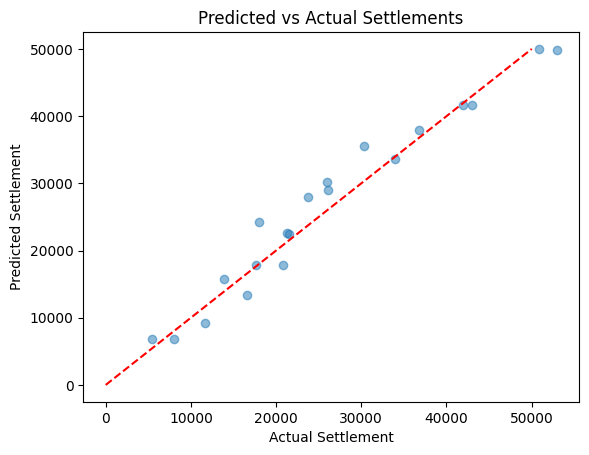

In [20]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Settlement")
plt.ylabel("Predicted Settlement")
plt.plot([0, max(y_pred)], [0, max(y_pred)], 'r--')
plt.title("Predicted vs Actual Settlements")
plt.show()

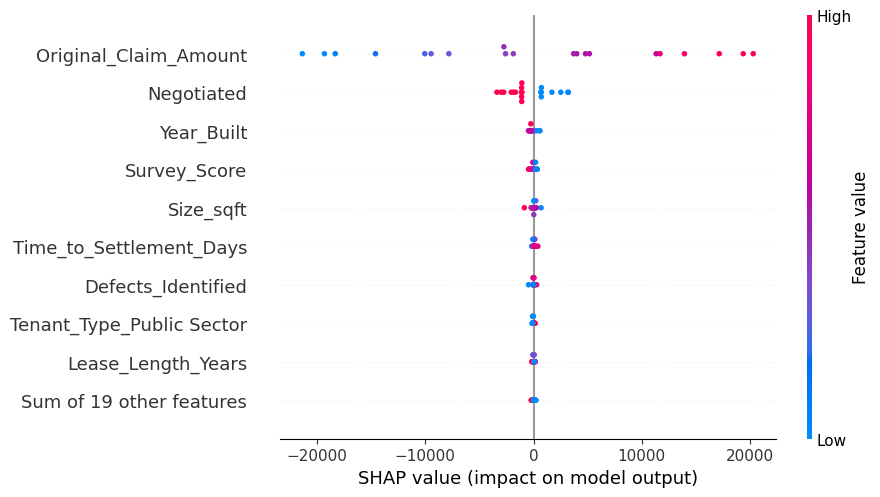

In [21]:
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()
for col in X_train_fixed.select_dtypes(include='bool').columns:
    X_train_fixed[col] = X_train_fixed[col].astype(int)
    X_test_fixed[col] = X_test_fixed[col].astype(int)

explainer = shap.Explainer(model, X_train_fixed)
shap_values = explainer(X_test_fixed)

shap.plots.beeswarm(shap_values)

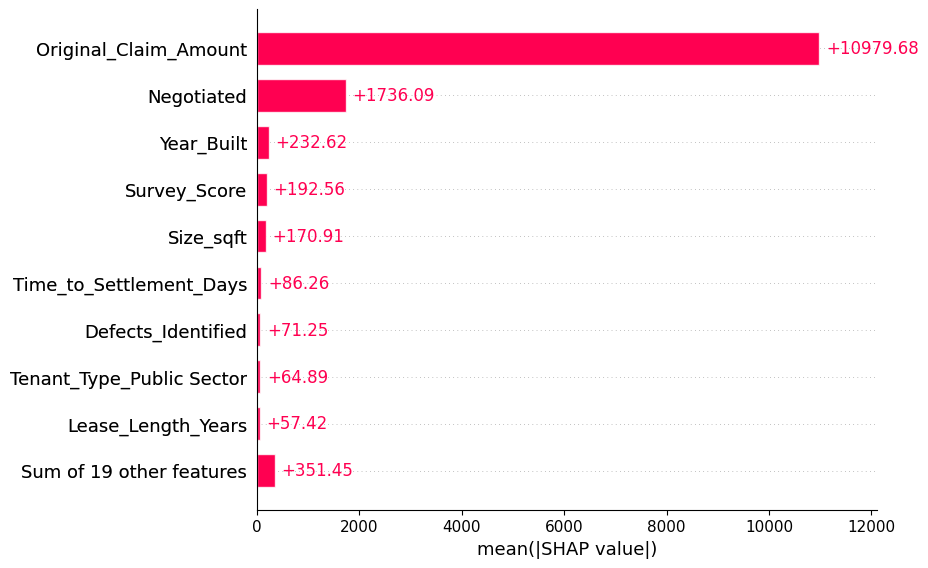

In [22]:
shap.plots.bar(shap_values)         

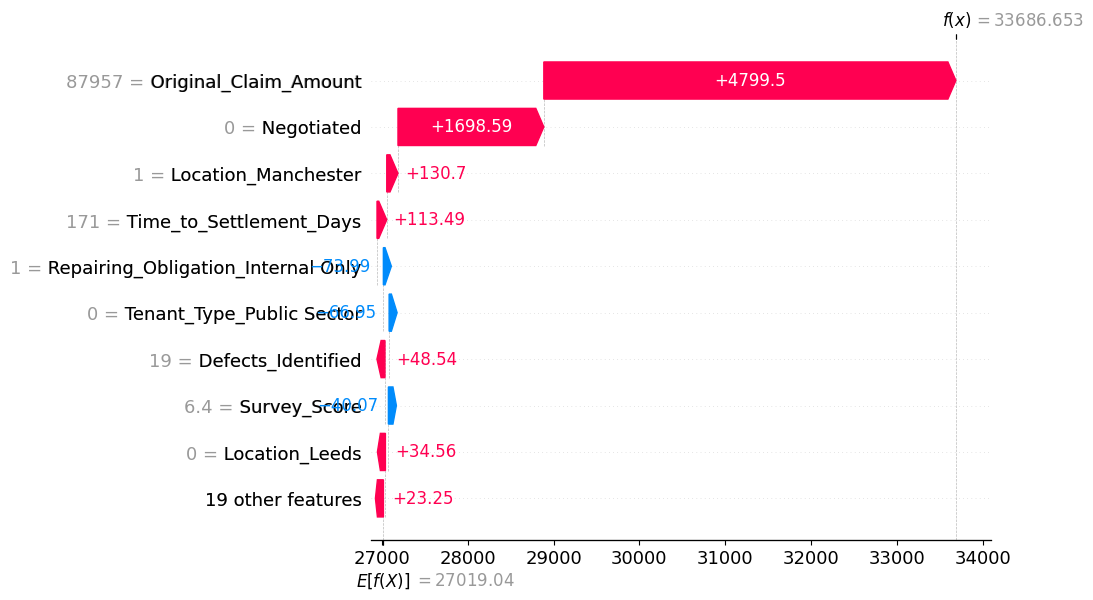

In [23]:
shap.plots.waterfall(shap_values[0])

In [24]:

joblib.dump(model, 'dilapidations_model.pkl')

['dilapidations_model.pkl']